# general idea

Notation:

1. `t'`: the observed earliest infection time

## ruling out possible sources

- nodes which has `t(v) > t'` cannot be the source
- so `mu(v)=0` for these nodes

## what about the rest?

1. for `v \in O`
2. simulate `k` cascades from `v` as source.
3. for each reversedly infected node, get the count for which it's valid candidate source according to `t'`

can be done in a multiplicative way

In [77]:
%matplotlib notebook
# starter code
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance
from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time

gtype = 'kr-hier'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.2

gvs = get_gvs(g, p, N2)

def gen_nontrivial_cascade(g, p, q, source=None):
    while True:
        source, c = simulate_cascade(g, p, source=source)
        obs_nodes = observe_cascade(c, source, q, method='uniform')
        cascade_size = np.sum(c != -1)

        if cascade_size >= 5:  # avoid small cascade
            break

    return c, source, obs_nodes

In [78]:
def sll_backtrack(g, gvs, obs_nodes, c, method='p', debug=True, eps=0.2):
    assert method in {'p', '1'}
    t_min = int(c[obs_nodes].min())
    t_max = int(c[obs_nodes].max())

    sll = np.ones(g.num_vertices())
    for o in obs_nodes:
        sll[o] = 0

    iters = obs_nodes
    if debug:
        iters = tqdm(iters)
    print(t_min, t_max)
    if debug:
        slls = []
        rs = []
    for o in iters:
        if debug:
            slls.append(sll)
        if method == 'p':
            votes = np.zeros(g.num_vertices())
            for gv in gvs:
                dist = get_infection_time(gv, source=o)
                source_times = c[o] - dist
                votes[source_times <= t_min] += 1
            mul = (eps + (1-eps) * (votes / len(gvs)))
            sll *= mul
        elif method == '1':
            cands = set()
            for gv in gvs:
                dist = get_infection_time(gv, source=o)
                source_times = c[o] - dist
                cands |= set(np.nonzero(source_times <= t_min)[0])
            mul = eps * np.ones(g.num_vertices())
            mul[list(cands)] = 1 - eps
            sll *= mul
        if debug:
            rs.append(mul)

        sll /= sll.sum()
    if debug:
        return sll, np.array(rs)
    else:
        return sll            

In [79]:
from utils import get_rank_index
def show_result(g, scores, source):
    winner = np.argmax(scores)
    if scores[source] == np.max(scores):
        print('rank[s]', 0)
    else:
        print('rank[s]', get_rank_index(scores, source))
    print('mu[winner]', scores.max())
    if scores[source] == np.max(scores):
        count = np.sum(scores == scores[source])
        print('mu[s]', scores[source], count)
    else:
        print('mu[s]', scores[source])
    print('d(winner, s)', shortest_distance(g, source=source, target=winner))
    print()

In [89]:
c, source, obs_nodes = gen_nontrivial_cascade(g, p, q)

from ic import sll_using_pairs

sll, rs = sll_backtrack(g, gvs, obs_nodes, c, method='p', eps=0.1)

print('using proba')
show_result(g, sll, source)

result = sll_using_pairs(
    g, obs_nodes, c, o2src_time=get_o2src_time(obs_nodes, gvs),
    method='order', precond_method='and', 
    source=source,
    eps=0.2, return_cascade=True, debug=False)
sll_pair, rs, pairs = result['sll'], result['rs'], result['pairs']

print('using pair')
show_result(g, sll_pair, source)

sll_together = sll_pair * sll
sll_together /= sll_together.sum()
print('together')
show_result(g, sll_together, source)

  9%|▉         | 1/11 [00:00<00:01,  6.79it/s]

3 11


100%|██████████| 11/11 [00:01<00:00,  9.08it/s]


using proba
rank[s] 30
mu[winner] 0.218121238633
mu[s] 0.00678216864938
d(winner, s) 4

using pair
rank[s] 32
mu[winner] 0.441606024121
mu[s] 1.7321303671e-07
d(winner, s) 4

together
rank[s] 31
mu[winner] 0.819068377303
mu[s] 9.98933034172e-09
d(winner, s) 4



<IPython.core.display.Javascript object>


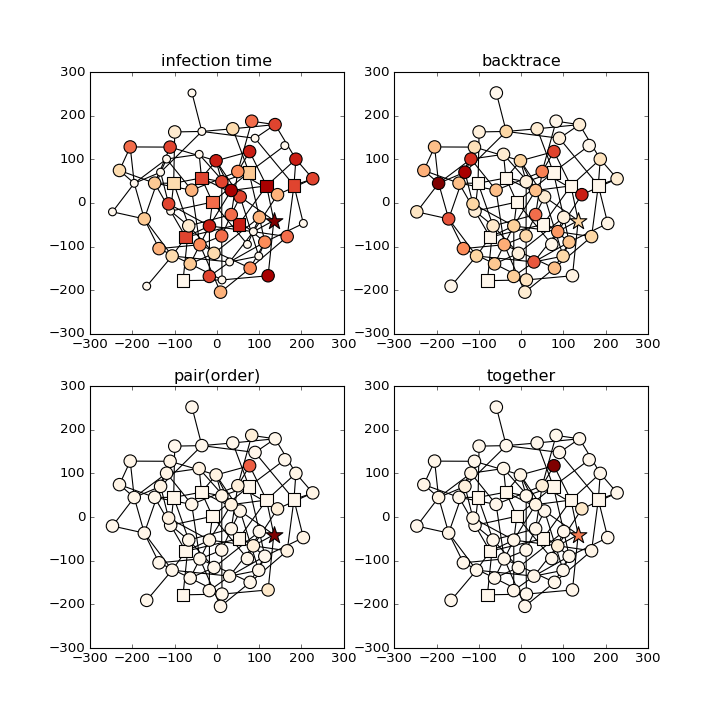

In [81]:
from matplotlib import pyplot as plt
from plot_utils import plot_snapshot
from utils import infeciton_time2weight
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(gnx, root=0)


fig, ax = plt.subplots(2, 2, figsize=(9, 9))
obs_nodes = list(obs_nodes)
plot_snapshot(gnx, pos,
              infeciton_time2weight({i: float(v) for i, v in enumerate(c)}),
              queried_nodes=obs_nodes,
              source_node=source,
              ax=ax[0, 0],
              max_node_size=500)
ax[0, 0].set_title('infection time')
for i, scores, title in zip(range(1, 4),
                            [sll, sll_pair, sll_together],
                            ['backtrace', 'pair(order)', 'together']):
    i, j = int(i / 2), int(i % 2)
    plot_snapshot(gnx, pos,
                  {i: float(v) for i, v in enumerate(scores)},
                  queried_nodes=obs_nodes,
                  source_node=source,
                  ax=ax[i, j],
                  max_node_size=500)
    ax[i, j].set_title(title)

# summary for today

- it's good to combine backtrace and pair method
- they seem to complement each other
- for backtrace, it does not consider the infection time order
- for pair method, it does not consider the absoluate infection time

gut feeling:

- compute the probability that `s` infects all nodes in `O`, instead using the backtrace method
- however, there is not obvious to easily update the score

question:

- what's the weakness for both methods?

In [ ]:
# from plot_utils import plot_query_process

# slls = [{i: v for i, v in enumerate(sll)}
#         for sll in slls1]
# obs_nodes = list(obs_nodes)
# plot_query_process(gnx, source, [], {i: float(v) for i, v in enumerate(c)},
#                    slls, obs_nodes, check_neighbor_threshold=0, pos=pos)